## <center> Modelo de Reclamaciones de Seguros </center>
Vinton Auto Insurance está tratando de decidir cuánto dinero debe mantener en activos líquidos para cubrir las reclamaciones de seguros. En el pasado, la empresa guardaba parte de las primas que recibía en cuentas corrientes que devengaban intereses y el resto lo invertía en activos que, aunque no son tan líquidos, suelen generar un mayor rendimiento. La compañía quiere estudiar los flujos de efectivo para determinar cuánto dinero debe mantener en activos líquidos para pagar las reclamaciones. Tras revisar los datos históricos, la empresa determinó que la factura promedio de reparación por siniestro se distribuye normalmente con una media de $1,700 y una desviación estándar de $400. También determinó que la cantidad de reclamaciones de reparación presentadas cada semana es una variable aleatoria que sigue la distribución de probabilidad que se muestra en la siguiente tabla:

$$
\begin{array}{c|ccccccccc}
\text{Reclamaciones} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\hline
\text{Probabilidad} & 0.05 & 0.06 & 0.10 & 0.17 & 0.28 & 0.14 & 0.08 & 0.07 & 0.05
\end{array}
$$

Además de las reclamaciones por reparaciones, la empresa también recibe reclamaciones por autos que han quedado en "pérdida total" y no se pueden reparar. Existe una probabilidad del 20 % de recibir este tipo de reclamación en cualquier semana. Estas reclamaciones por autos en  "pérdida total" suelen costar entre 2,000 y 35,000 dólares, siendo 13,000 dólares el coste más habitual.

### 0. Análisis Número de Reclamos

In [120]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar si el número de reclamos por semana son Poisson

# Datos observados
reclamos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
f_relativa = np.array([0.05, 0.06, 0.10, 0.17, 0.28, 0.14, 0.08, 0.07, 0.05])

# Calcular el parámetro lambda (media esperada)
lambda_estimada =np.sum(reclamos * f_relativa)

# Calcular la distribución teórica de Poisson con lambda estimada
poisson_teorica = stats.poisson.pmf(reclamos, lambda_estimada)

# Suposicion del tamaño de la muestra
N_100 = 100
f_observada = f_relativa * N_100
f_esperada = poisson_teorica * N_100
# print(f'observada: {f_observada}\nesperada: {f_esperada}')

# Agrupación de clases
f_obs_nueva = [f_observada[0] + f_observada[1],
               f_observada[2], f_observada[3],
               f_observada[4], f_observada[5], f_observada[6],
               f_observada[7] + f_observada[8]]

f_esp_nueva = [f_esperada[0] + f_esperada[1],
               f_esperada[2], f_esperada[3],
               f_esperada[4], f_esperada[5], f_esperada[6],
               f_esperada[7] + f_esperada[8]]

# Realizar la prueba chi-cuadrado
stats.chisquare(f_obs_nueva, f_esp_nueva,ddof=-1,sum_check=False)

Power_divergenceResult(statistic=np.float64(8.608359107961459), pvalue=np.float64(0.28200994095474113))

### 1. Entradas Conocidas

In [103]:
# Media de la distribución de Poisson
lambda_frecuencia  = lambda_estimada

# Parámetros de la distribución normal reparaciones
mu_rep, sigma_rep = 1700, 400

# Parámetros distribució triangular pérdida total
min_pt, mod_pt, max_pt = 2000, 13000, 35000

# Parámetro distribución Bernoulli pérdida total
prob = 0.20

# Número de ensayos de Montecarlo
n_sim = 1000


### 2. Variables de Decisión

In [ ]:
activos_liquidos = 20000

### 3. Entradas Inciertas

In [ ]:
# Generar número de reclamaciones
def r_reparacion(u):
    return stats.poisson.rvs(u)

# Pago total reparaciones
def pago_reparaciones(localizacion, escala, frecuencia):
    pagos = stats.norm.rvs(loc=localizacion, scale=escala, size=frecuencia)
    return pagos

# Pago pérdida total
def p_perdida_total(minimo, moda, maximo):
    moda_rel = (moda-minimo)/(maximo-minimo)
    localizacion = minimo
    escala = maximo - minimo
    return stats.triang.rvs(moda_rel,localizacion,escala)

# Verificar si en la semana hubo pérdid total
def h_perdida_total(p_exito):
    return stats.bernoulli.rvs(p_exito,loc=0)

### 4. Calculos Intermedios

In [116]:
def simular_perdidas(ensayos):
    pagos_totales = []
    for _ in range(ensayos):
        frec_simulada = r_reparacion(lambda_frecuencia)
        severidad_sim = pago_reparaciones(mu_rep, sigma_rep, frec_simulada)
        severidad_perdida_total_sim = h_perdida_total(prob) * p_perdida_total(min_pt,mod_pt,max_pt)
        pagos_totales.append(np.sum(severidad_sim) + severidad_perdida_total_sim)
    return pagos_totales

### 5. Salida

In [129]:
pago_total_semanal = simular_perdidas(n_sim)
condicion= (np.array(pago_total_semanal) > 20000)
prob1=np.sum(condicion)/len(pago_total_semanal)
print(f'Pago promedio semanal = {np.mean(pago_total_semanal):.4f}')
print(f'Máximo pago semanal = {np.max(pago_total_semanal):.4f}')
print(f'Mínimo pago semanal = {np.min(pago_total_semanal):.4f}')
print(f"P(Pago Total > 20000) = {prob1:.2f}")

Pago promedio semanal = 11346.2931
Máximo pago semanal = 44561.7280
Mínimo pago semanal = 0.0000
P(Pago Total > 20000) = 0.13


### 6. Resume

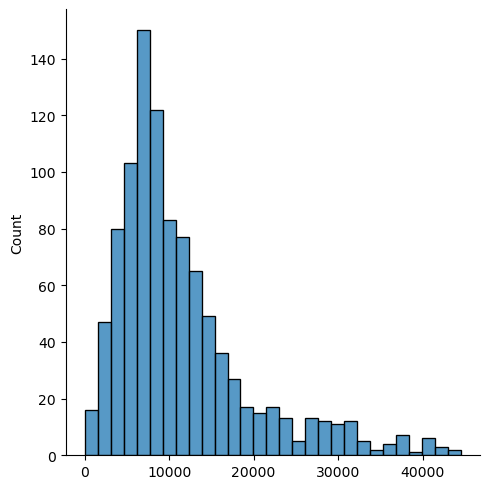

In [130]:
sns.displot(pago_total_semanal)

In [6]:
import numpy as np
from scipy.stats import chisquare
chisquare(
    f_obs=[11, 10, 17, 28, 14, 8, 12],
    f_exp=[12.806, 14.26241762, 17.68539784, 17.54391466,
    14.50296945, 10.27638978, 9.883],
    ddof=-1,
    axis=0,
    sum_check=False
    )

Power_divergenceResult(statistic=np.float64(8.762060322896357), pvalue=np.float64(0.270193610560183))

In [2]:
import scipy
print(scipy.__version__)

1.15.2
